<a href="https://colab.research.google.com/github/FelixBra/Brain-MRI-Images-for-Brain-Tumor-Detection/blob/master/Brain_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [17]:
os.chdir("/gdrive/My Drive/Brain MRI Images for Brain Tumor Detection")
print(os.listdir())

['preview', '.ipynb_checkpoints', 'data', 'Brain.ipynb']


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

#print(os.listdir())

['.config', 'Y2.jpg', 'sample_data']


In [18]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #rescale=1/255,  #just deactivated for def plots()
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.15)
        
batch_size = 10

train_generator = datagen.flow_from_directory(
        "/gdrive/My Drive/Brain MRI Images for Brain Tumor Detection/data/",  
        target_size=(224, 224),
        batch_size=batch_size, class_mode='categorical',
        classes=["no", "yes"],subset="training")

validation_generator = datagen.flow_from_directory("/gdrive/My Drive/Brain MRI Images for Brain Tumor Detection/data/",target_size=(224, 224),class_mode='categorical',
                                                     classes=["no", "yes"], batch_size=batch_size, subset="validation")

Found 216 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [0]:
def plots(ims, figsize=(12,6), rows = 1, interp=False, titles=None):
    #print(type(ims[0]))
    
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims, dtype='uint8')
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else "none")
        

input shape: (10, 224, 224, 3)


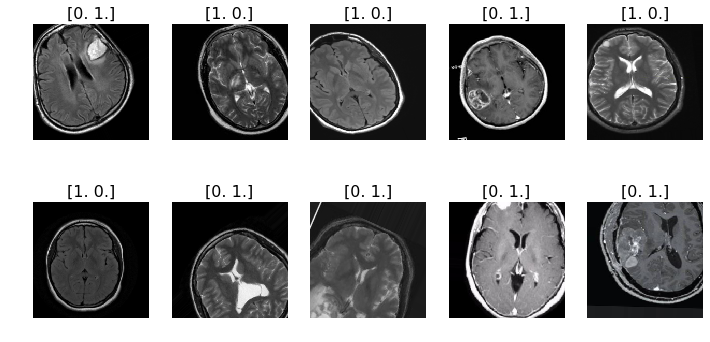

In [19]:
test_imgs, test_labels = next(train_generator)
print("input shape:",test_imgs.shape)
plots(test_imgs, titles=test_labels, rows=2)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class TrainModel:
    
    def __init__(self, train_generator, lr: float = 0.001, epochs: int=10,batch_size: int = 32,
                 loss: str = 'categorical_crossentropy'):
        self.train_generator = train_generator
        self.validation_generator = validation_generator
                
        self.epochs = epochs
        self.batch_size = batch_size

        self.optimizer = Adam(lr=lr)
        self.loss = loss

    def create_model(self, summarize: bool = True):
        model= Sequential()
        model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
        model.add(MaxPooling2D((2,2)))
        model.add(Conv2D(filters = 32, kernel_size = 1, activation = 'relu'))
        model.add(Conv2D(64,(3,3),activation='relu'))
        model.add(MaxPooling2D((2,2)))
        model.add(Conv2D(128,(3,3),activation='relu'))
        model.add(MaxPooling2D((2,2)))
        model.add(Conv2D(128,(3,3),activation='relu'))
        model.add(MaxPooling2D((2,2)))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dense(2,activation='sigmoid'))
        
        if summarize:
            model.summary()

        return model    
    
    def compile(self, kmodel: Sequential):
        kmodel.compile(loss=self.loss,optimizer=self.optimizer,metrics=['acc'])
        
        return kmodel
    
    def train(self, kmodel: Sequential):
        history = kmodel.fit_generator(self.train_generator,steps_per_epoch=100,epochs=10,validation_data=validation_generator,
                            validation_steps=50) 
        return history, kmodel

In [0]:
def plot_training_curves(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Losses')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Accuracies')
    plt.legend()
    plt.figure()
    
    plt.show()

In [15]:
trainer = TrainModel(train_generator, epochs=10, batch_size=1024, lr=0.0002)

model = trainer.create_model()
model = trainer.compile(model)

history = trainer.train(model)

history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=10,validation_data=validation_generator,
                            validation_steps=50) 
                         

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      1056      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_

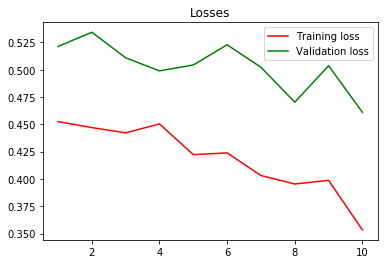

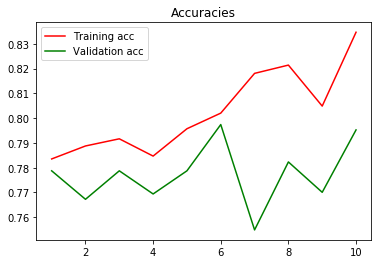

<Figure size 432x288 with 0 Axes>

In [16]:
plot_training_curves(history)